# Chapter 1: Logistic Regression 
## Section  1: Preprocessing the data
--------------------------------------------------------------------------------------------------------------------------------------------------


### Methodology
We will start with trying out logistic regression on a realtively small dataset, particularly the https://archive.ics.uci.edu/dataset/470/parkinson+s+disease+classification dataset.

Since our problem relies on voice features, due to the motor-related nature of PD, we will need to see which features are most important. We will look at preprocessed datasets first, keeping note of the most important features, and trying to generalize at the end to be able to fully extract the needed features for a highly accurate classification from raw voices, and be able to predict early PD from that.


Important libraries, put in one block cell to make it easier to run other cells without dependancy on a library found randomly on some cell (won't put libraries used in only 1 cell, wil keep them only in the cell).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, learning_curve

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score, mean_squared_error, mean_absolute_error,r2_score,accuracy_score, classification_report, confusion_matrix,roc_curve, auc, roc_auc_score, precision_recall_curve,average_precision_score, log_loss, brier_score_loss

# Added: Suppress irrelevant warnings to focus on actual issues
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)  # Suppress convergence warnings as max_iter is sufficient
warnings.filterwarnings("ignore", message="Setting penalty=None will ignore")  # Suppress penalty warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress future deprecation warnings

n_job = 6 # Adjust  to your machine, less = less load, each n is a core

# Create output directories if they don't exist
import os
os.makedirs("../../Figures", exist_ok=True)
os.makedirs("../../Results", exist_ok=True)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Extract Data

Make the data ready to be used:

In [2]:
df = pd.read_csv("parkinsons.data")

#Separate features and target
X = df.drop(columns=["name", "status"]) #No need for these in data
y = df["status"]
groups = df["name"] #Use name as group divider (naturally)
print(f"size of X:{X.shape}")

size of X:(195, 22)


**We will do a simple showing of the correlations of the features to the output, just to get an idea of the most important features, as well as the features to themselves to see which are redundant.**


Feature correlations with Parkinson's status:
spread1                   0.565
PPE                       0.531
spread2                   0.455
MDVP:Shimmer              0.367
MDVP:APQ                  0.364
Shimmer:APQ5              0.351
MDVP:Shimmer(dB)          0.351
Shimmer:APQ3              0.348
Shimmer:DDA               0.348
D2                        0.340
MDVP:Jitter(Abs)          0.339
RPDE                      0.309
MDVP:PPQ                  0.289
MDVP:Jitter(%)            0.278
MDVP:RAP                  0.267
Jitter:DDP                0.267
DFA                       0.232
NHR                       0.189
MDVP:Fhi(Hz)              -0.166
HNR                       -0.362
MDVP:Flo(Hz)              -0.380
MDVP:Fo(Hz)               -0.384


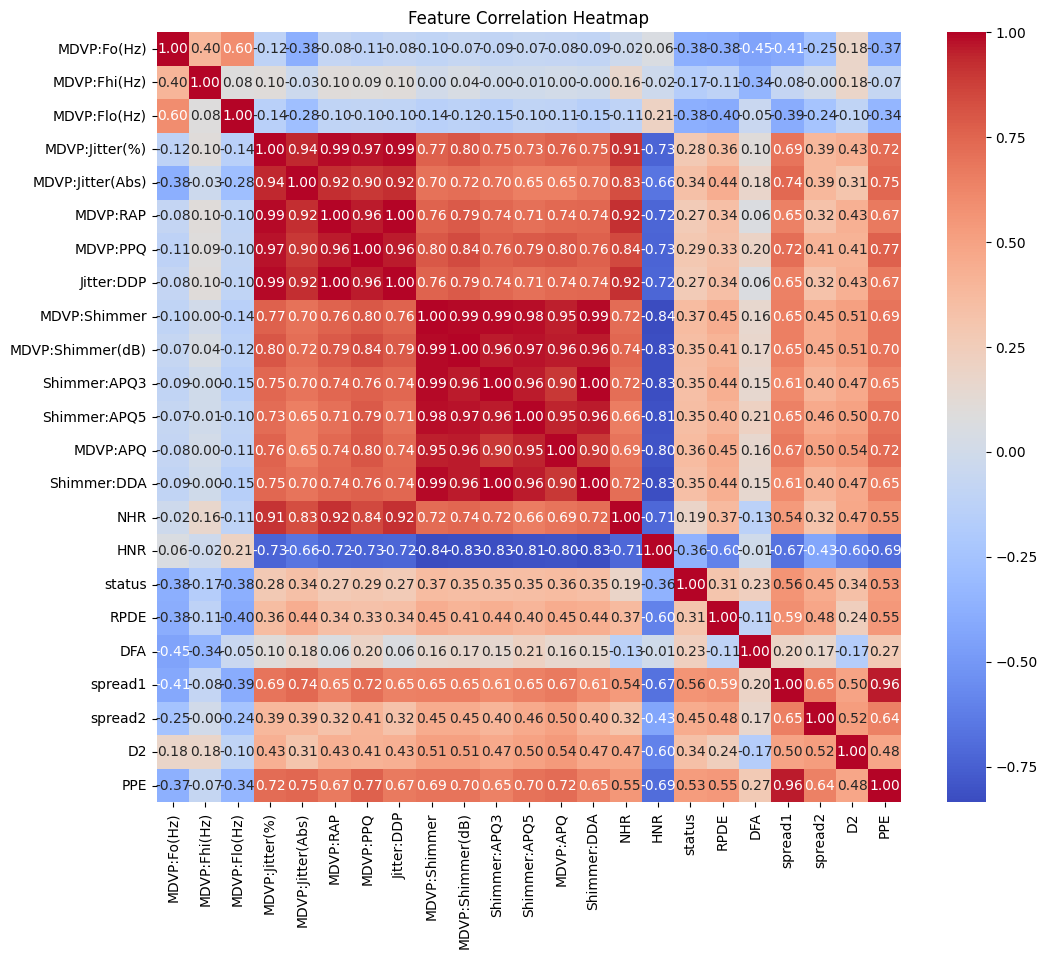

In [3]:
#find correlation between status and variables
corr = df.drop(columns=["name"]).corr()["status"].sort_values(ascending=False)

print("\nFeature correlations with Parkinson's status:")
for feature, value in corr.drop("status").items():
    print(f"{feature:25s} {value:.3f}")


#plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.drop(columns=["name"]).corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

We notice a lot of redundancy as apparent from the very high (0.94+) correlation values between features.

We then notice, a lot of our features are the same feature, but measured in different measurement, such as MDVP:Jitter(%), and MDVP:Jitter(Abs), being metrics for the same thing. Keeping both featrues is redundant and adds noise for no reason, so we will drop one of the two, and do the same thing for all features that have such redundancy existing in it (Apq3*3 = DDA, db vs raw, RAP vs DDP).

MDVP:Fo(Hz)              
MDVP:Fhi(Hz)             
MDVP:Flo(Hz)             
MDVP:Jitter(%)           
MDVP:RAP                 
MDVP:PPQ                 
MDVP:Shimmer(dB)         
Shimmer:APQ3             
Shimmer:APQ5             
MDVP:APQ                 
NHR                      
HNR                      
RPDE                     
DFA                      
spread1                  
spread2                  
D2                       
PPE                      


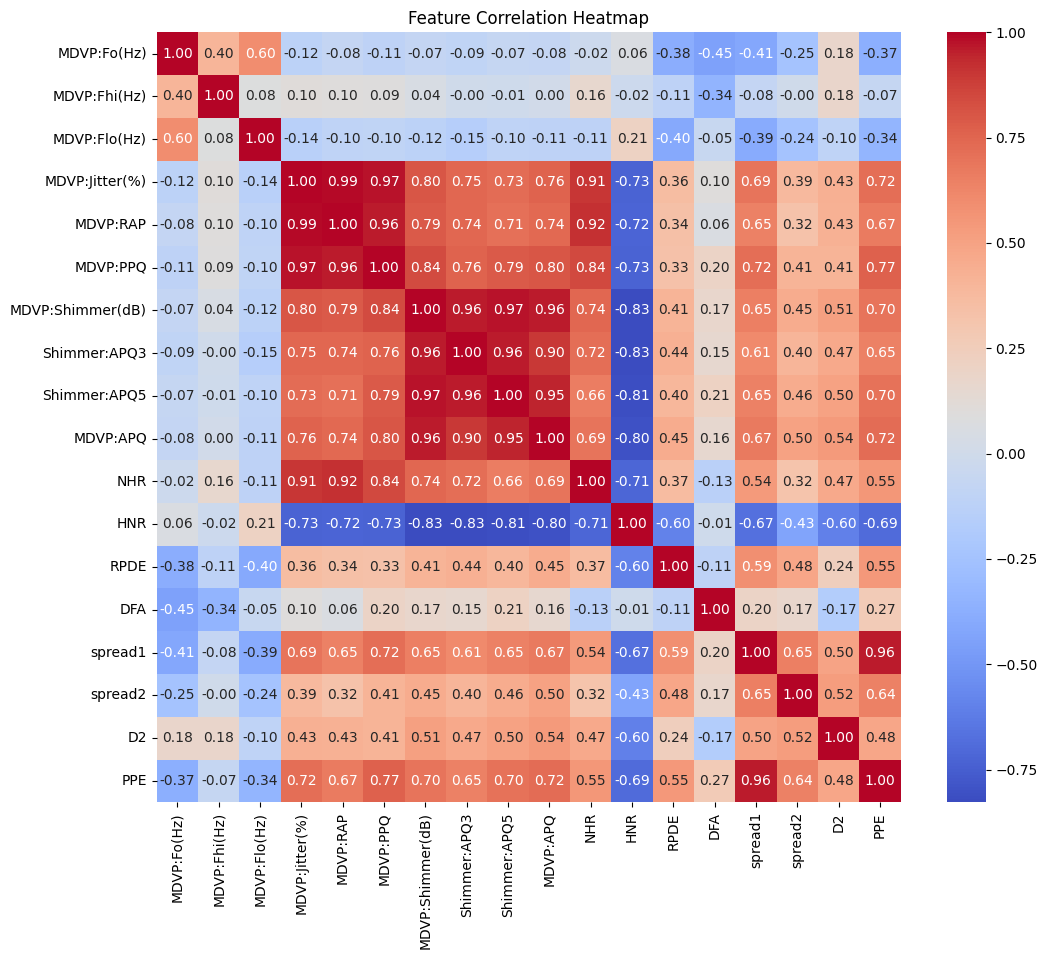

In [4]:
X1 = X.drop(columns=["MDVP:Shimmer","MDVP:Jitter(Abs)","Shimmer:DDA","Jitter:DDP"])
for feature in X1.columns:
    print(f"{feature:25s}")

plt.figure(figsize=(12, 10))
sns.heatmap(X1.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

We notice redundency still exists

MDVP:Jitter(%), MDVP:RAP, and MDVP:PPQ are all highly corelated(0,97-0.99), as they all measure voice jitter/period perturbation. We will need to drop two of three to avoid redundancy, we will keep MDVP:jitter(%) since it is the simplest and most straightforward measure of the 3. 

Also MDVP:Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, and MDVP:APQ, all highly correlated. We will drop MDVP:Shimmer(dB), and shimmer:apq5, since they have the  highest correlation to everything among these 4 features.

PPE and spread1 are highly correlated (0.96), we will keep PPE of the 2 since it's a more sophisticated nonlinear measure of fundamental frequency variation, while spread1 is a simpler measure of the same thing. 

MDVP:Fo(Hz)              
MDVP:Fhi(Hz)             
MDVP:Flo(Hz)             
MDVP:Jitter(%)           
Shimmer:APQ3             
MDVP:APQ                 
NHR                      
HNR                      
RPDE                     
DFA                      
spread2                  
D2                       
PPE                      


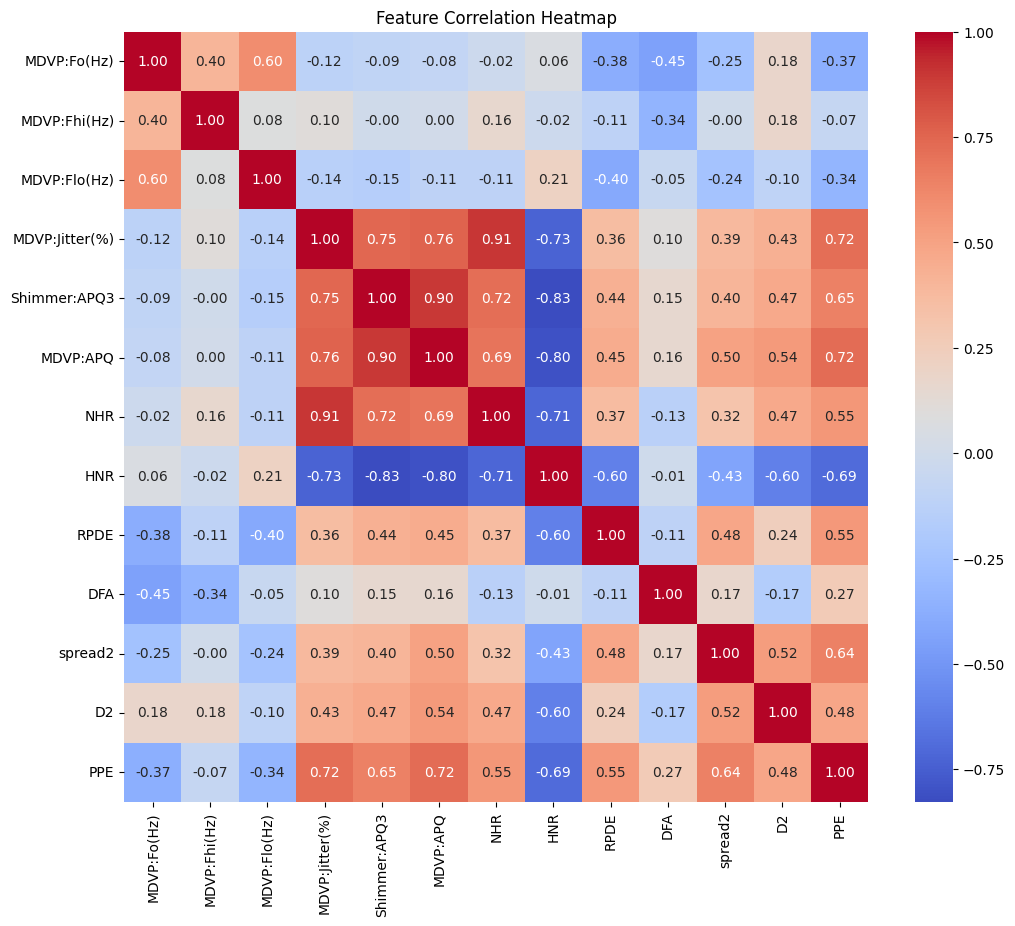

In [5]:
X_reduced = X1.drop(columns=["MDVP:RAP","MDVP:PPQ","Shimmer:APQ5","MDVP:Shimmer(dB)","spread1"])
for feature in X_reduced.columns:
    print(f"{feature:25s}")

plt.figure(figsize=(12, 10))
sns.heatmap(X_reduced.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

For the most part, we got rid of high correlation hence redundancy and noise.

Now we will see what are the most important features:

To find out the important features, we see research such as the research.pdf found in the drive, which utilized the same data set we are using, reached a similar feature set to ours, which is reassuring that we indeed eliminated only redundant features.

We will also now try to use multiple models on our feature set, and see the coefficients to find the features with most significance.

Before we continue, we will just show our final feature set:

In [6]:
print(X_reduced.head())

print(f"size of X:{X_reduced.shape}")

   MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  Shimmer:APQ3  \
0      119.992       157.302        74.997         0.00784       0.02182   
1      122.400       148.650       113.819         0.00968       0.03134   
2      116.682       131.111       111.555         0.01050       0.02757   
3      116.676       137.871       111.366         0.00997       0.02924   
4      116.014       141.781       110.655         0.01284       0.03490   

   MDVP:APQ      NHR     HNR      RPDE       DFA   spread2        D2       PPE  
0   0.02971  0.02211  21.033  0.414783  0.815285  0.266482  2.301442  0.284654  
1   0.04368  0.01929  19.085  0.458359  0.819521  0.335590  2.486855  0.368674  
2   0.03590  0.01309  20.651  0.429895  0.825288  0.311173  2.342259  0.332634  
3   0.03772  0.01353  20.644  0.434969  0.819235  0.334147  2.405554  0.368975  
4   0.04465  0.01767  19.649  0.417356  0.823484  0.234513  2.332180  0.410335  
size of X:(195, 13)


We reduced our original 22 features to only 12, very good for efficiency and noise-elimination.

## Section 2: Testing


## Trial one, using logistic regression
--------------------------------------------------------------------------------------------------------------------------------------------------


We first see the 0/1 split in our dataset

In [7]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_reduced, y, groups))
X_train, X_test = X_reduced.iloc[train_idx], X_reduced.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
print(f"y original values {y.value_counts()}")

print(f"y test values {y_test.value_counts()}")


y original values status
1    147
0     48
Name: count, dtype: int64
y test values status
1    32
0     7
Name: count, dtype: int64


We notice not an equal balance of 0 and 1s, nor equal ratio of 0 and 1 between test and original, so we'll utilize stratified splits to guarantee to ghet an equal split.

#### **The actual Trial**

We will now try applying logistic regression to our X set and see the results.

We will allow for higher powers than 1 on features, since we will try to capture nonlinear relationships if possible.

*Note that since we have multiple voice samples per patient, we will split by group as to avoid data leakage (correlation from voice to voice being from the same patient) and to get more accurate results. So each group will include all the voice samples of a given patient, and a group can be in only 1 set, train, val, or test.*


In [8]:

#group-aware and imbalance aware train/test split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_idx = next(sgkf.split(X_reduced, y, groups))

X_train, X_test = X_reduced.iloc[train_idx], X_reduced.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]
y_test.value_counts()

status
1    28
0    11
Name: count, dtype: int64

Notice we got a closer ratio to the amount we want to reflect the original dataset's ratio, which will mean we will now generalize better to the dataset.

Since our data set is small (195 samples) we will use kfold validation.

We will try each of l1, l2, and no regualrization, on different models, and see which performs best.

In [9]:
#pipeline
pipe = Pipeline([
    ("poly",   PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=2000,
        random_state=42
    ))
])
gkf_inner = GroupKFold(n_splits=5)

Cs = np.logspace(-4, 2, 25)
# Valid solver/penalty combos for this sklearn:

param_grid = [
    {
        "poly__degree": [1, 2,3,4],
        "logreg__solver": ["lbfgs"],
        "logreg__penalty": ["l2", None],
        "logreg__C": Cs
    },
    {
        "poly__degree": [1, 2, 3,4],
        "logreg__solver": ["saga"],
        "logreg__penalty": ["l1", "l2", None],
        "logreg__C": Cs,
    }
]


grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=gkf_inner,
    scoring="accuracy",
    n_jobs=n_job,
    verbose=2
)

grid.fit(X_train, y_train, groups=groups_train)


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'logreg__C': array([1.0000...00000000e+02]), 'logreg__penalty': ['l2', None], 'logreg__solver': ['lbfgs'], 'poly__degree': [1, 2, ...]}, {'logreg__C': array([1.0000...00000000e+02]), 'logreg__penalty': ['l1', 'l2', ...], 'logreg__solver': ['saga'], 'poly__degree': [1, 2, ...]}]"
,scoring,'accuracy'
,n_jobs,6
,refit,True
,cv,GroupKFold(n_...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,4


Best params (CV on train): {'logreg__C': np.float64(0.03162277660168379), 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'poly__degree': 4}
Best mean CV accuracy (train): 0.9102822580645162

=== FINAL TEST EVALUATION ===
Test accuracy: 0.8974358974358975
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.88      1.00      0.93        28

    accuracy                           0.90        39
   macro avg       0.94      0.82      0.86        39
weighted avg       0.91      0.90      0.89        39


=== Generating Learning Curves ===


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\AppData\Loca

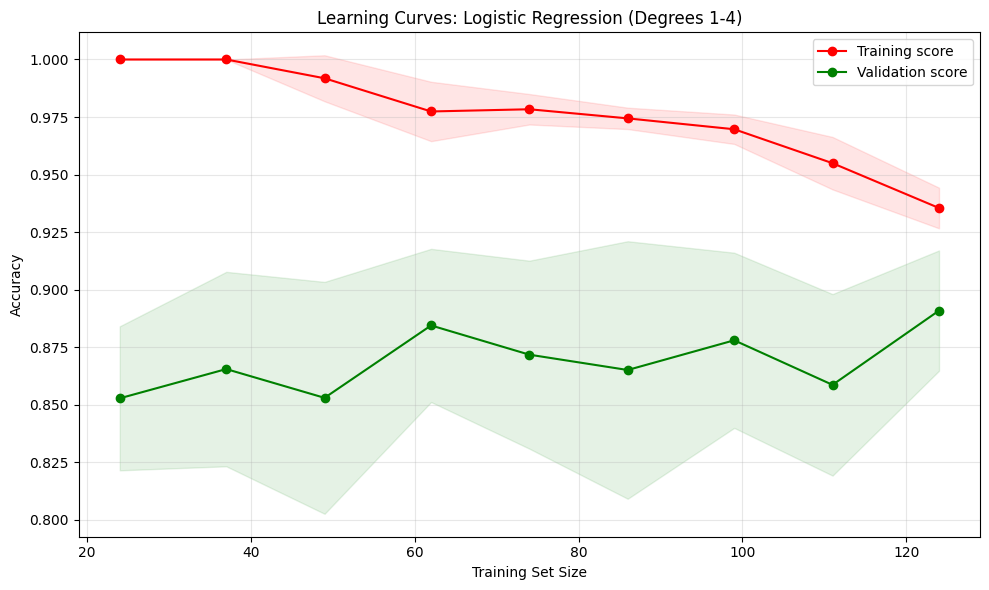

All results saved to ../../Results/logreg_results_Ch1.csv


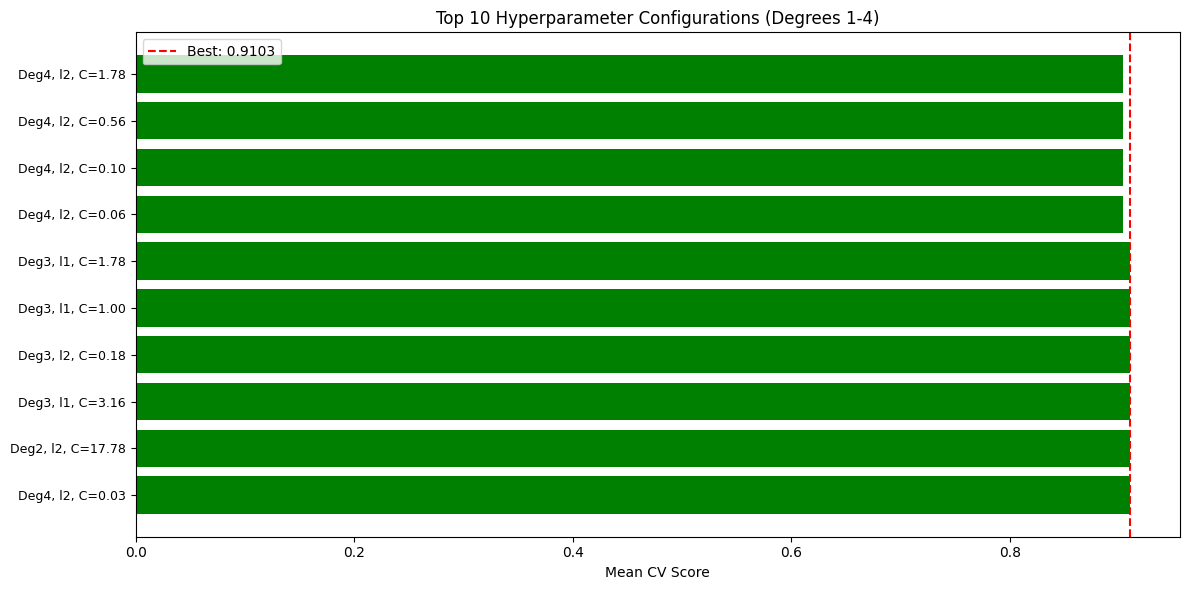

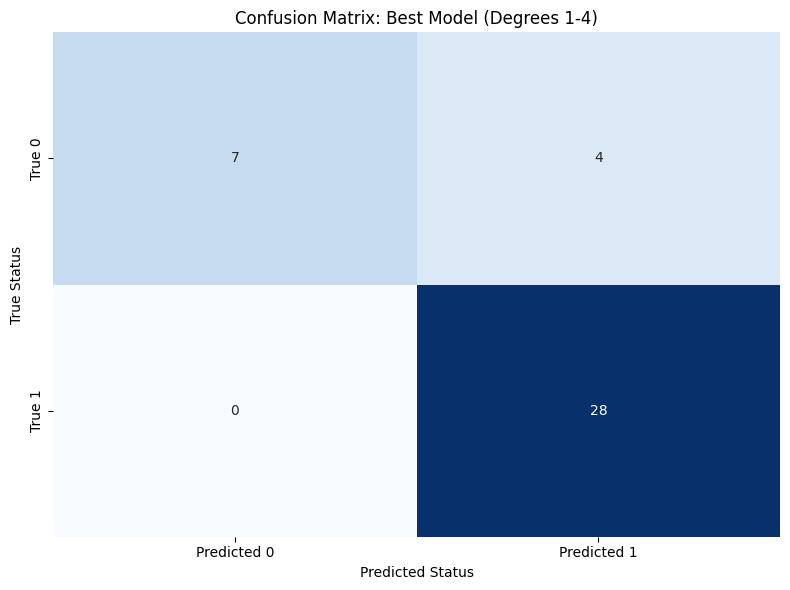

In [10]:

print("Best params (CV on train):", grid.best_params_)
print("Best mean CV accuracy (train):", grid.best_score_)

# Refit on full TRAIN and evaluate once on TEST
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print("\n=== FINAL TEST EVALUATION ===")
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Added: Training/validation learning curves for overfitting analysis
print("\n=== Generating Learning Curves ===")
train_sizes, train_scores, val_scores = learning_curve(
    grid.best_estimator_, X_train, y_train, 
    cv=GroupKFold(n_splits=5), groups=groups_train,
    train_sizes=np.linspace(0.1, 1.0, 10), 
    scoring='accuracy', n_jobs=n_job)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves: Logistic Regression (Degrees 1-4)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../../Figures/logreg_learning_curve_deg1-4.png", dpi=300, bbox_inches='tight')
plt.show()

# === After grid search ===
results_df = pd.DataFrame(grid.cv_results_)

# Extract relevant info
records = []
for i, row in results_df.iterrows():
    params = row["params"]
    solver = params["logreg__solver"]
    degree = params["poly__degree"]
    penalty = params["logreg__penalty"]
    C = params["logreg__C"]
    l1_ratio = params.get("logreg__l1_ratio", None)
    
    record = {
        "method": "LogisticRegression",
        "solver": solver,
        "degree": degree,
        "alpha": 1.0 / C,   # inverse of C
        "generalization": penalty if penalty != "elasticnet" else f"elasticnet(l1_ratio={l1_ratio})",
        "score": row["mean_test_score"]
    }
    records.append(record)

summary_df = pd.DataFrame(records)

summary_df.to_csv("../../Results/logreg_results_Ch1.csv", index=False)
print("All results saved to ../../Results/logreg_results_Ch1.csv")

# Added: Hyperparameter comparison bar chart
top_10 = summary_df.nlargest(10, 'score')
plt.figure(figsize=(12, 6))
bars = plt.barh(range(len(top_10)), top_10['score'], 
                color=['green' if s > grid.best_score_ - 0.01 else 'steelblue' for s in top_10['score']])
plt.yticks(range(len(top_10)), 
           [f"Deg{r['degree']}, {r['generalization']}, C={1/r['alpha']:.2f}" 
            for _, r in top_10.iterrows()], fontsize=9)
plt.xlabel('Mean CV Score')
plt.title('Top 10 Hyperparameter Configurations (Degrees 1-4)')
plt.axvline(x=grid.best_score_, color='red', linestyle='--', label=f'Best: {grid.best_score_:.4f}')
plt.legend()
plt.tight_layout()
plt.savefig("../../Figures/logreg_hyperparams_deg1-4.png", dpi=300, bbox_inches='tight')
plt.show()

# === Plot predictions vs truth for best model ===
y_pred = best_model.predict(X_test)


y_pred = grid.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
# Use seaborn for a nice heatmap visualization
sns.heatmap(
    cm,
    annot=True,
    fmt='d', # 'd' formats the numbers as integers
    cmap='Blues',
    cbar=False,
    xticklabels=['Predicted 0', 'Predicted 1'],
    yticklabels=['True 0', 'True 1']
)
plt.xlabel('Predicted Status')
plt.ylabel('True Status')
plt.title('Confusion Matrix: Best Model (Degrees 1-4)')
plt.tight_layout()
plt.savefig("../../Figures/logreg_confusion_deg1-4.png", dpi=300, bbox_inches='tight')
plt.show()


### ROC Curve Analysis

ROC (Receiver Operating Characteristic) curves visualize the trade-off between true positive rate and false positive rate across different classification thresholds.

In [ ]:
# Generate ROC curve for best model
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression (Degrees 1-4)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../../Figures/logreg_roc_deg1-4.png", dpi=300, bbox_inches='tight')
plt.show()

# Print comprehensive metrics summary
print("\n" + "="*70)
print("COMPREHENSIVE EVALUATION METRICS (Degrees 1-4)")
print("="*70)
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("="*70)

### Regularization Strength (C) Ablation Study

We systematically vary the regularization parameter C to understand its impact on model performance. Smaller C values mean stronger regularization (simpler models), while larger C values allow more complex decision boundaries.

In [ ]:
# Hyperparameter Ablation: Test different C values systematically
C_values = np.logspace(-3, 3, 15)  # 15 values from 0.001 to 1000
degree_test = 3  # Use degree 3 as baseline

train_scores_c = []
val_scores_c = []

print("Testing regularization strength (C) ablation...")
for C_val in C_values:
    # Create pipeline
    pipe_temp = Pipeline([
        ("poly", PolynomialFeatures(degree=degree_test, include_bias=False)),
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(C=C_val, penalty='l2', solver='lbfgs', 
                                      max_iter=2000, random_state=42))
    ])
    
    # Cross-validation scores
    gkf = GroupKFold(n_splits=5)
    scores = []
    for train_idx, val_idx in gkf.split(X_train, y_train, groups=groups_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        pipe_temp.fit(X_t, y_t)
        train_scores_c.append(pipe_temp.score(X_t, y_t))
        val_scores_c.append(pipe_temp.score(X_v, y_v))
        scores.append(pipe_temp.score(X_v, y_v))
    
    print(f"C={C_val:.4f}: Mean Val Accuracy = {np.mean(scores):.4f}")

# Aggregate scores by C value
train_scores_agg = [np.mean(train_scores_c[i*5:(i+1)*5]) for i in range(len(C_values))]
val_scores_agg = [np.mean(val_scores_c[i*5:(i+1)*5]) for i in range(len(C_values))]

# Plot ablation results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(C_values, train_scores_agg, 'o-', label='Training Score', color='blue')
plt.plot(C_values, val_scores_agg, 's-', label='Validation Score', color='green')
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Accuracy')
plt.title(f'Hyperparameter Ablation: C vs Performance (Degree {degree_test})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
gaps = np.array(train_scores_agg) - np.array(val_scores_agg)
plt.plot(C_values, gaps, 'o-', color='red')
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Overfitting Gap (Train - Val)')
plt.title('Overfitting Analysis')
plt.axhline(y=0.05, color='orange', linestyle='--', label='5% threshold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../../Figures/logreg_C_ablation_deg1-4.png", dpi=300, bbox_inches='tight')
plt.show()

# Find optimal C
optimal_idx = np.argmax(val_scores_agg)
optimal_C = C_values[optimal_idx]
print(f"\nOptimal C value: {optimal_C:.4f}")
print(f"Best validation accuracy: {val_scores_agg[optimal_idx]:.4f}")
print(f"Overfitting gap at optimal C: {gaps[optimal_idx]:.4f}")

### Overfitting vs Underfitting Analysis

------------------------------------------------------------------------------------------------------------------------------------------------------

**Current Model Status:**

Examining the learning curves and train-validation gaps reveals whether our model is overfitting or underfitting:

- **Overfitting indicators**: Large gap between training and validation scores, high training accuracy but lower validation accuracy
- **Underfitting indicators**: Both training and validation scores are low and similar
- **Good fit indicators**: Small gap (< 5%), both scores are reasonably high

**Diagnosis and Mitigation:**

Based on the C ablation study and learning curves, we can identify if regularization adjustments are needed.

In [ ]:
# Overfitting Analysis: Compare different regularization strategies
print("="*70)
print("OVERFITTING VS UNDERFITTING ANALYSIS")
print("="*70)

# Test weak regularization (potential overfitting)
pipe_weak_reg = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(C=100.0, penalty='l2', solver='lbfgs', max_iter=2000, random_state=42))
])

# Test strong regularization (potential underfitting)
pipe_strong_reg = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(C=0.01, penalty='l2', solver='lbfgs', max_iter=2000, random_state=42))
])

# Test optimal regularization
pipe_optimal = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(C=optimal_C, penalty='l2', solver='lbfgs', max_iter=2000, random_state=42))
])

configs = [
    ("Weak Regularization (C=100)", pipe_weak_reg),
    ("Strong Regularization (C=0.01)", pipe_strong_reg),
    (f"Optimal Regularization (C={optimal_C:.3f})", pipe_optimal)
]

results_comparison = []

for name, model in configs:
    # Cross-validation
    gkf = GroupKFold(n_splits=5)
    train_scores_fold = []
    val_scores_fold = []
    
    for train_idx, val_idx in gkf.split(X_train, y_train, groups=groups_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_t, y_t)
        train_scores_fold.append(model.score(X_t, y_t))
        val_scores_fold.append(model.score(X_v, y_v))
    
    train_mean = np.mean(train_scores_fold)
    val_mean = np.mean(val_scores_fold)
    gap = train_mean - val_mean
    
    # Test on hold-out set
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    results_comparison.append({
        'Configuration': name,
        'Train Acc': train_mean,
        'Val Acc': val_mean,
        'Test Acc': test_score,
        'Overfit Gap': gap
    })
    
    print(f"\n{name}:")
    print(f"  Train Accuracy: {train_mean:.4f}")
    print(f"  Val Accuracy:   {val_mean:.4f}")
    print(f"  Test Accuracy:  {test_score:.4f}")
    print(f"  Overfit Gap:    {gap:.4f}")
    
    if gap > 0.10:
        print(f"  → ⚠️  OVERFITTING detected!")
    elif gap < 0.02:
        print(f"  → ✓  Good generalization")
    else:
        print(f"  → ⚡ Slight overfitting")

# Visualize comparison
comparison_df = pd.DataFrame(results_comparison)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Performance comparison
ax = axes[0]
x = np.arange(len(comparison_df))
width = 0.25
ax.bar(x - width, comparison_df['Train Acc'], width, label='Train', color='blue', alpha=0.7)
ax.bar(x, comparison_df['Val Acc'], width, label='Validation', color='green', alpha=0.7)
ax.bar(x + width, comparison_df['Test Acc'], width, label='Test', color='orange', alpha=0.7)
ax.set_xlabel('Configuration')
ax.set_ylabel('Accuracy')
ax.set_title('Performance Comparison: Different Regularization Levels')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Configuration'], rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Overfitting gap comparison
ax = axes[1]
colors = ['red' if g > 0.05 else 'green' for g in comparison_df['Overfit Gap']]
ax.bar(comparison_df['Configuration'], comparison_df['Overfit Gap'], color=colors, alpha=0.7)
ax.axhline(y=0.05, color='orange', linestyle='--', linewidth=2, label='5% threshold')
ax.set_ylabel('Train-Val Gap')
ax.set_title('Overfitting Analysis')
ax.set_xticklabels(comparison_df['Configuration'], rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("../../Figures/logreg_overfitting_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("CONCLUSION:")
print("="*70)
best_idx = comparison_df['Val Acc'].idxmax()
print(f"Best configuration: {comparison_df.loc[best_idx, 'Configuration']}")
print(f"Validation Accuracy: {comparison_df.loc[best_idx, 'Val Acc']:.4f}")
print(f"Test Accuracy: {comparison_df.loc[best_idx, 'Test Acc']:.4f}")
print(f"Overfitting Gap: {comparison_df.loc[best_idx, 'Overfit Gap']:.4f}")
print("="*70)

We will now run some metrics to see if we are overfitting, and what did best for features:

MODEL EVALUATION


Best CV Score (Train): 0.9103
Test Accuracy          : 0.8974
Test ROC-AUC           : 0.9513

Train-Test Gap       : 0.0128
Good generalization

Best Parameters:
Polynomial Degree: 4
Regularization C : 0.0316
Penalty          : l2


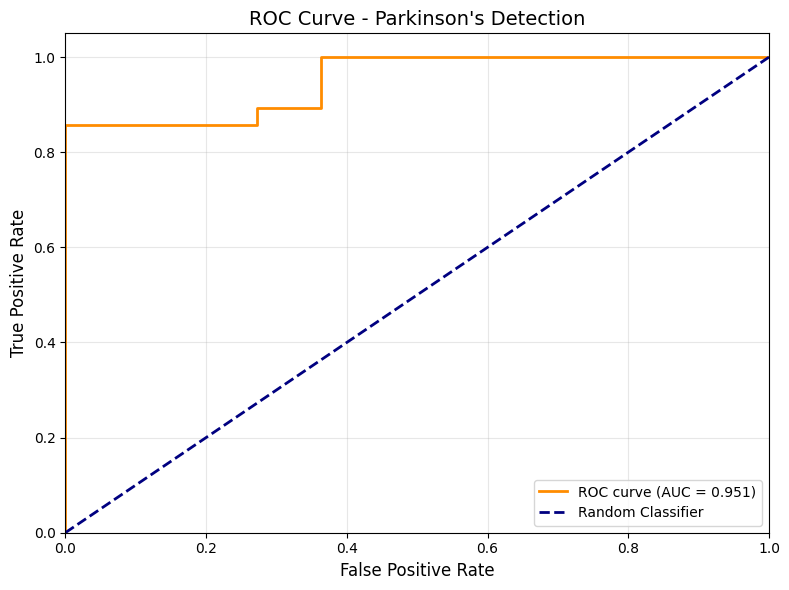

MODEL COEFFICIENTS

Intercept: 3.2786
Total features after polynomial expansion: 2379

Top 15 Most Important Features:
                      Feature  Coefficient  Abs_Coefficient
   MDVP:Fo(Hz)^3 MDVP:Fhi(Hz)    -0.061682         0.061682
                MDVP:Fo(Hz)^4    -0.060529         0.060529
                   HNR^2 D2^2     0.060304         0.060304
             MDVP:Fo(Hz)^3 D2    -0.053999         0.053999
            HNR DFA^2 spread2    -0.050655         0.050655
      MDVP:Flo(Hz) HNR RPDE^2    -0.050331         0.050331
MDVP:Fo(Hz)^2 MDVP:Fhi(Hz) D2    -0.049755         0.049755
                 HNR DFA D2^2     0.045881         0.045881
                     HNR D2^2     0.045159         0.045159
        MDVP:Fo(Hz)^2 NHR HNR    -0.044682         0.044682
 MDVP:Fo(Hz)^2 MDVP:Fhi(Hz)^2    -0.044526         0.044526
                       HNR D2     0.043624         0.043624
                MDVP:Fo(Hz)^3    -0.043347         0.043347
        MDVP:Fo(Hz) HNR^2 PPE     0.04333

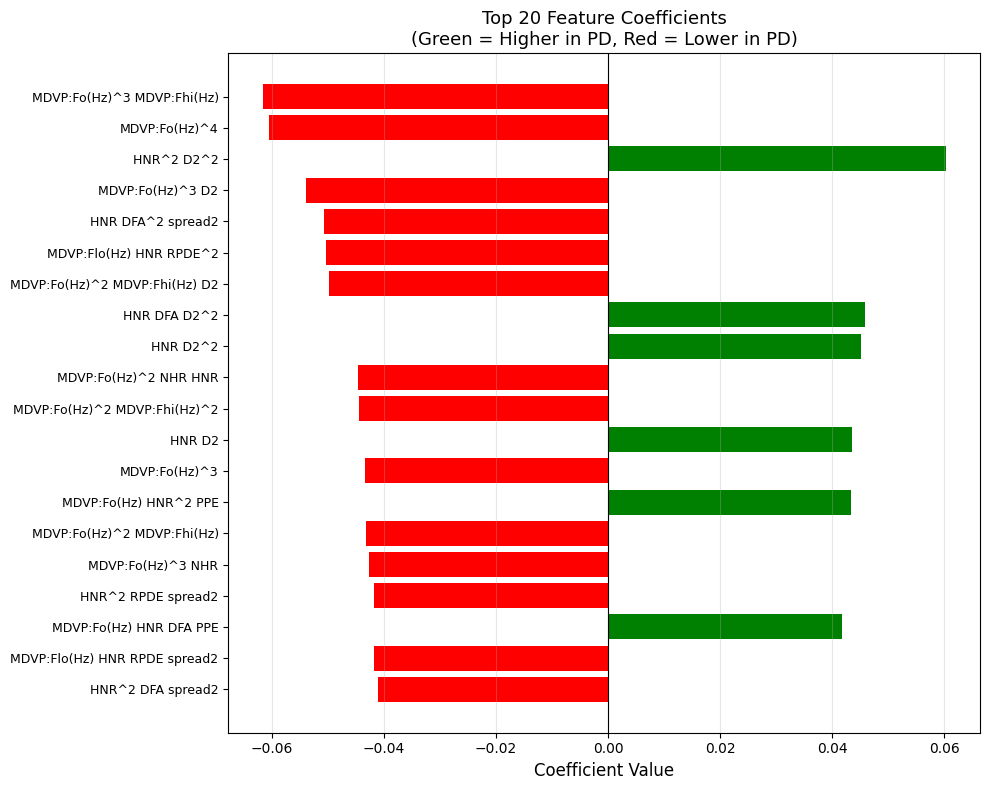

In [11]:
#testing for overfitting usin g simple train-test gap as metric
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("MODEL EVALUATION\n")
print("=" * 60)
print(f"\nBest CV Score (Train): {grid.best_score_:.4f}")
print(f"Test Accuracy          : {accuracy_score(y_test, y_pred):.4f}")
print(f"Test ROC-AUC           : {roc_auc_score(y_test, y_pred_proba):.4f}")

# Overfitting check
gap = grid.best_score_ - accuracy_score(y_test, y_pred)
print(f"\nTrain-Test Gap       : {gap:.4f}")
if abs(gap) < 0.05:
    print("Good generalization")
elif abs(gap) < 0.10:
    print("Slight overfitting detected")
else:
    print("Significant overfitting")

print(f"\nBest Parameters:")
print(f"Polynomial Degree: {grid.best_params_['poly__degree']}")
print(f"Regularization C : {grid.best_params_['logreg__C']:.4f}")
print(f"Penalty          : {grid.best_params_['logreg__penalty']}")

#Roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Parkinson\'s Detection', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#Model coefficients

print("MODEL COEFFICIENTS")
print("=" * 60)
logreg = best_model.named_steps['logreg']
poly = best_model.named_steps['poly']

# Get feature names
if hasattr(poly, 'get_feature_names_out'):
    feature_names = poly.get_feature_names_out()
else:
    feature_names = [f"feature_{i}" for i in range(len(logreg.coef_[0]))]

coefficients = logreg.coef_[0]
intercept = logreg.intercept_[0]

print(f"\nIntercept: {intercept:.4f}")
print(f"Total features after polynomial expansion: {len(coefficients)}")

# Top coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 15 Most Important Features:")
print(coef_df.head(15).to_string(index=False))

# Plot top coefficients
plt.figure(figsize=(10, 8))
top_n = 20
top_coefs = coef_df.head(top_n)
colors = ['red' if x < 0 else 'green' for x in top_coefs['Coefficient']]
plt.barh(range(len(top_coefs)), top_coefs['Coefficient'].values, color=colors)
plt.yticks(range(len(top_coefs)), top_coefs['Feature'].values, fontsize=9)
plt.xlabel('Coefficient Value', fontsize=12)
plt.title(f'Top {top_n} Feature Coefficients\n(Green = Higher in PD, Red = Lower in PD)', fontsize=13)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)

### *Analysis*
--------------------------------------------------------------------------------------------------------------------------------------------------

From the above, we conclude saga solver seems to give worse results for l2, as apparent from the results csv, and that both l1 and l2 regularization improving our resutls, with two degrees standing out as optimal, 3 and 4.

We will need to test on degree 5 to see if we can add more complexity safely or not.

It seems that MDVP:FO(hz) is a very important metric, being used in most top 20 important coefficients. Additionally, spread 2 seems very important as well, also appearing very commonly.

It also seems that the relationship between the features and the output is nonlinear, as most significant features are mostly higher powers one (only exceptions are spread2 and MDVP:FO(HZ)).

--------------------------------------------------------------------------------------------------------------------------------------------------


#### Trying degree 5

As we mentioned, we will need to try out degree 5 to see if we can benefit from more complex models:

testing for previously done stuff:

In [12]:
Cs = np.logspace(-4, 1, 30) #We lower possible range of values since computing for degree 5+ is expensive
pipe = Pipeline([
    ("poly",   PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=2000,
        random_state=42
    ))
])
gkf_inner = GroupKFold(n_splits=5)
# Valid solver/penalty combos for this sklearn:
param_grid = [
    {
        "poly__degree": [4,5],
        "logreg__solver": ["lbfgs"],
        "logreg__penalty": ["l2", None],
        "logreg__C": Cs
    },
    {
        "poly__degree": [4,5],
        "logreg__solver": ["saga"],
        "logreg__penalty": ["l1", None],
        "logreg__C": Cs
    }
]

grid =  GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=gkf_inner,
    scoring="accuracy",
    n_jobs=n_job,
    verbose=2
)

grid.fit(X_train, y_train, groups=groups_train)



Fitting 5 folds for each of 240 candidates, totalling 1200 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'logreg__C': array([1.0000...00000000e+01]), 'logreg__penalty': ['l2', None], 'logreg__solver': ['lbfgs'], 'poly__degree': [4, 5]}, {'logreg__C': array([1.0000...00000000e+01]), 'logreg__penalty': ['l1', None], 'logreg__solver': ['saga'], 'poly__degree': [4, 5]}]"
,scoring,'accuracy'
,n_jobs,6
,refit,True
,cv,GroupKFold(n_...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,5


Best params (CV on train): {'logreg__C': np.float64(0.011721022975334805), 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'poly__degree': 5}
Best mean CV accuracy (train): 0.9102822580645162

=== FINAL TEST EVALUATION ===
Test accuracy: 0.8974358974358975
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.88      1.00      0.93        28

    accuracy                           0.90        39
   macro avg       0.94      0.82      0.86        39
weighted avg       0.91      0.90      0.89        39


=== Generating Learning Curves (Deg 4-5) ===


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\AppData\Loca

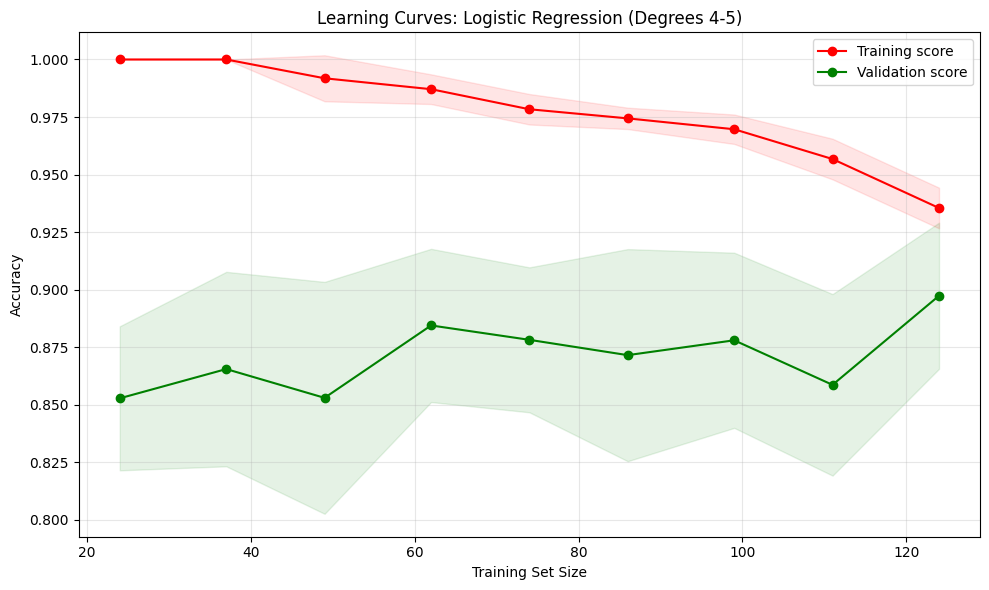

All results saved to ../../Results/logreg_Ch1_deg_4_5.csv


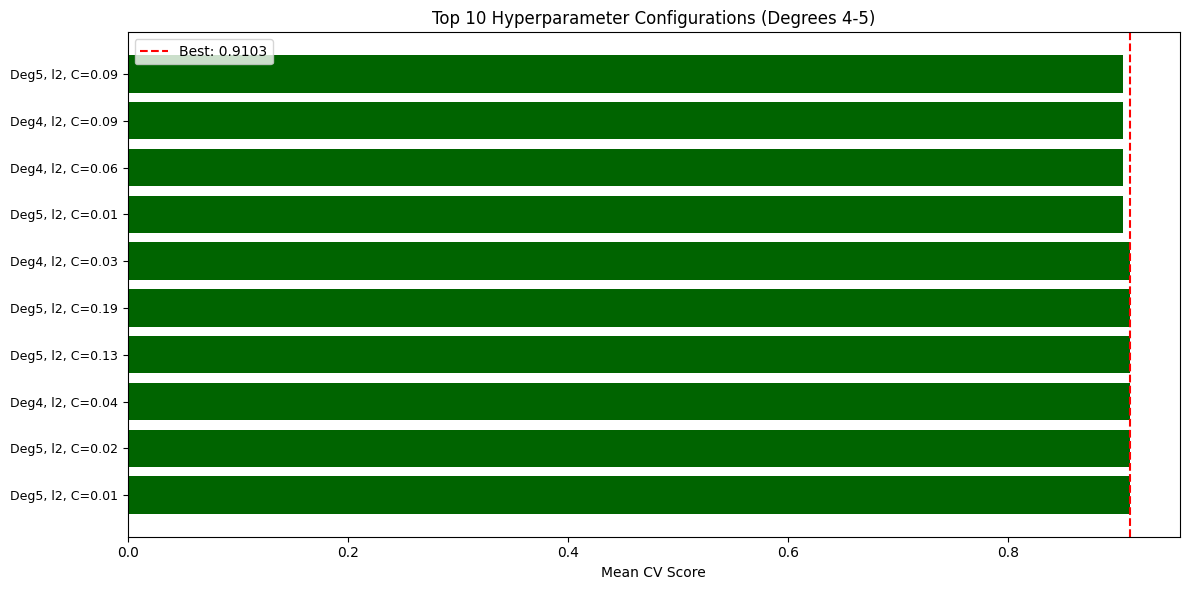

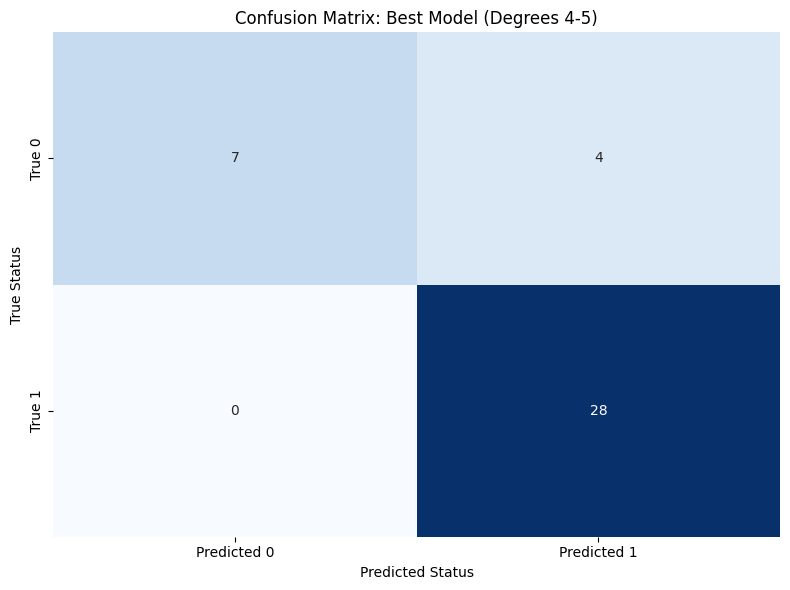

In [13]:
#Save results and test deg 3,4
print("Best params (CV on train):", grid.best_params_)
print("Best mean CV accuracy (train):", grid.best_score_)

# Refit on full TRAIN and evaluate once on TEST
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)


y_pred = best_model.predict(X_test)
print("\n=== FINAL TEST EVALUATION ===")
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Added: Learning curves for degrees 4-5
print("\n=== Generating Learning Curves (Deg 4-5) ===")
train_sizes, train_scores, val_scores = learning_curve(
    grid.best_estimator_, X_train, y_train, 
    cv=GroupKFold(n_splits=5), groups=groups_train,
    train_sizes=np.linspace(0.1, 1.0, 10), 
    scoring='accuracy', n_jobs=n_job)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves: Logistic Regression (Degrees 4-5)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../../Figures/logreg_learning_curve_deg4-5.png", dpi=300, bbox_inches='tight')
plt.show()

# === After grid search ===
# Save all CV results
results_df = pd.DataFrame(grid.cv_results_)


#Do not save, dataset i did as big as it realistically gets



# Extract relevant info
records = []
for i, row in results_df.iterrows():
    params = row["params"]
    solver = params["logreg__solver"]
    degree = params["poly__degree"]
    penalty = params["logreg__penalty"]
    C = params["logreg__C"]
    l1_ratio = params.get("logreg__l1_ratio", None)
    
    record = {
        "method": "LogisticRegression",
        "solver": solver,
        "degree": degree,
        "alpha": 1.0 / C,   # inverse of C
        "generalization": penalty if penalty != "elasticnet" else f"elasticnet(l1_ratio={l1_ratio})",
        "score": row["mean_test_score"]
    }
    records.append(record)

summary_df = pd.DataFrame(records)

# Save to CSV
summary_df.to_csv("../../Results/logreg_Ch1_deg_4_5.csv", index=False)
print("All results saved to ../../Results/logreg_Ch1_deg_4_5.csv")

# Added: Bar chart for top configurations
top_10 = summary_df.nlargest(10, 'score')
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_10)), top_10['score'], 
         color=['darkgreen' if s > grid.best_score_ - 0.01 else 'coral' for s in top_10['score']])
plt.yticks(range(len(top_10)), 
           [f"Deg{r['degree']}, {r['generalization']}, C={1/r['alpha']:.2f}" 
            for _, r in top_10.iterrows()], fontsize=9)
plt.xlabel('Mean CV Score')
plt.title('Top 10 Hyperparameter Configurations (Degrees 4-5)')
plt.axvline(x=grid.best_score_, color='red', linestyle='--', label=f'Best: {grid.best_score_:.4f}')
plt.legend()
plt.tight_layout()
plt.savefig("../../Figures/logreg_hyperparams_deg4-5.png", dpi=300, bbox_inches='tight')
plt.show()

#Confusion
y_pred = grid.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
# Use seaborn for a nice heatmap visualization
sns.heatmap(
    cm,
    annot=True,
    fmt='d', # 'd' formats the numbers as integers
    cmap='Blues',
    cbar=False,
    xticklabels=['Predicted 0', 'Predicted 1'],
    yticklabels=['True 0', 'True 1']
)
plt.xlabel('Predicted Status')
plt.ylabel('True Status')
plt.title('Confusion Matrix: Best Model (Degrees 4-5)')
plt.tight_layout()
plt.savefig("../../Figures/logreg_confusion_deg4-5.png", dpi=300, bbox_inches='tight')
plt.show()


Same checks as above:

MODEL EVALUATION


Best CV Score (Train): 0.9103
Test Accuracy          : 0.8974
Test ROC-AUC           : 0.9545

Train-Test Gap       : 0.0128
Good generalization

Best Parameters:
Polynomial Degree: 5
Regularization C : 0.0117
Penalty          : l2


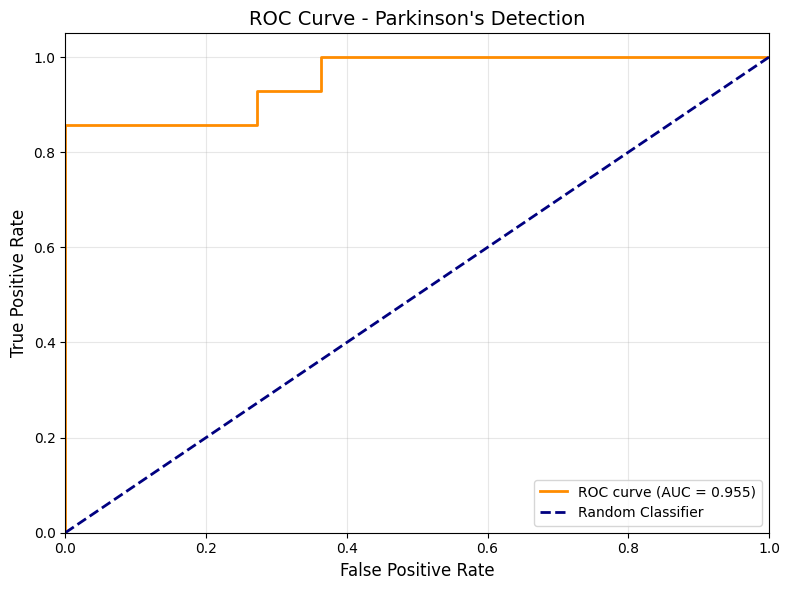

MODEL COEFFICIENTS

Intercept: 3.4173
Total features after polynomial expansion: 8567

Top 15 Most Important Features:
                      Feature  Coefficient  Abs_Coefficient
   MDVP:Fo(Hz)^4 MDVP:Fhi(Hz)    -0.024716         0.024716
                MDVP:Fo(Hz)^5    -0.023677         0.023677
                   HNR^3 D2^2     0.023461         0.023461
        MDVP:Fo(Hz)^3 NHR HNR    -0.023207         0.023207
             MDVP:Fo(Hz)^4 D2    -0.023108         0.023108
MDVP:Fo(Hz)^3 MDVP:Fhi(Hz) D2    -0.022666         0.022666
                   HNR^2 D2^2     0.022187         0.022187
                   HNR^2 D2^3     0.022133         0.022133
            HNR DFA^3 spread2    -0.021326         0.021326
               HNR^2 DFA D2^2     0.021324         0.021324
                    NHR HNR^4     0.021207         0.021207
          HNR^2 DFA^2 spread2    -0.020463         0.020463
 MDVP:Fo(Hz)^3 MDVP:Fhi(Hz)^2    -0.020355         0.020355
   MDVP:Fo(Hz)^3 MDVP:Fhi(Hz)    -0.02010

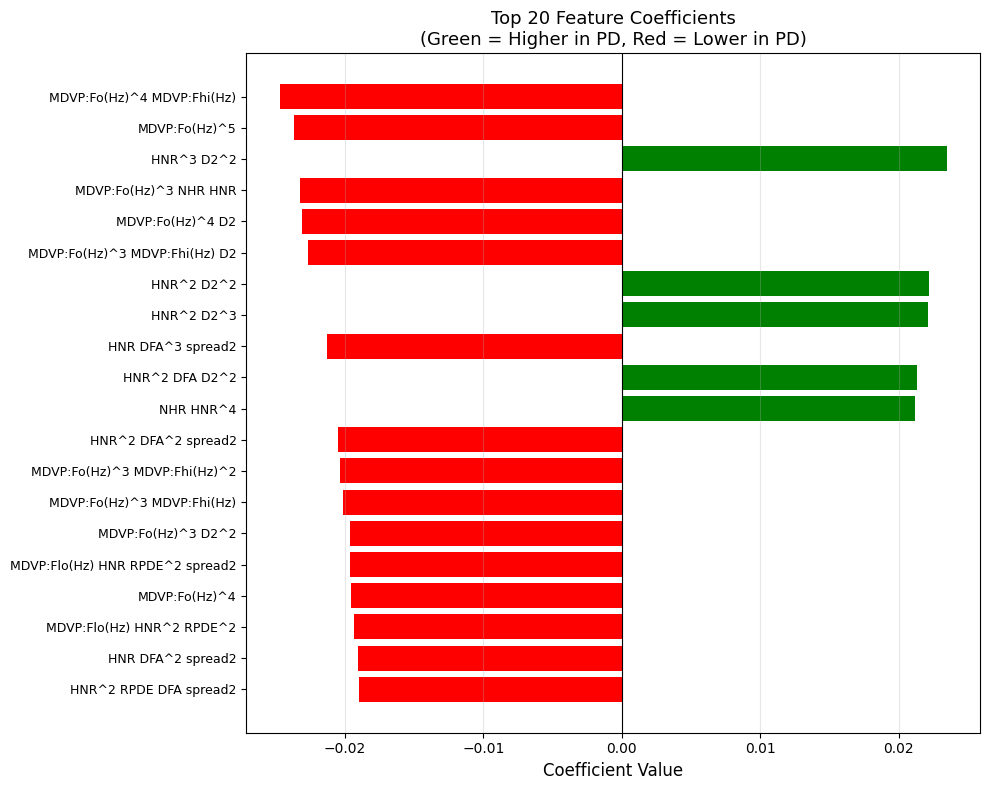

In [14]:
#testing for overfitting usin g simple train-test gap as metric
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("MODEL EVALUATION\n")
print("=" * 60)
print(f"\nBest CV Score (Train): {grid.best_score_:.4f}")
print(f"Test Accuracy          : {accuracy_score(y_test, y_pred):.4f}")
print(f"Test ROC-AUC           : {roc_auc_score(y_test, y_pred_proba):.4f}")

# Overfitting check
gap = grid.best_score_ - accuracy_score(y_test, y_pred)
print(f"\nTrain-Test Gap       : {gap:.4f}")
if abs(gap) < 0.05:
    print("Good generalization")
elif abs(gap) < 0.10:
    print("Slight overfitting detected")
else:
    print("Significant overfitting")

print(f"\nBest Parameters:")
print(f"Polynomial Degree: {grid.best_params_['poly__degree']}")
print(f"Regularization C : {grid.best_params_['logreg__C']:.4f}")
print(f"Penalty          : {grid.best_params_['logreg__penalty']}")

#Roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Parkinson\'s Detection', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#Model coefficients

print("MODEL COEFFICIENTS")
print("=" * 60)
logreg = best_model.named_steps['logreg']
poly = best_model.named_steps['poly']

# Get feature names
if hasattr(poly, 'get_feature_names_out'):
    feature_names = poly.get_feature_names_out()
else:
    feature_names = [f"feature_{i}" for i in range(len(logreg.coef_[0]))]

coefficients = logreg.coef_[0]
intercept = logreg.intercept_[0]

print(f"\nIntercept: {intercept:.4f}")
print(f"Total features after polynomial expansion: {len(coefficients)}")

# Top coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 15 Most Important Features:")
print(coef_df.head(15).to_string(index=False))

# Plot top coefficients
plt.figure(figsize=(10, 8))
top_n = 20
top_coefs = coef_df.head(top_n)
colors = ['red' if x < 0 else 'green' for x in top_coefs['Coefficient']]
plt.barh(range(len(top_coefs)), top_coefs['Coefficient'].values, color=colors)
plt.yticks(range(len(top_coefs)), top_coefs['Feature'].values, fontsize=9)
plt.xlabel('Coefficient Value', fontsize=12)
plt.title(f'Top {top_n} Feature Coefficients\n(Green = Higher in PD, Red = Lower in PD)', fontsize=13)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)

### Analysis

--------------------------------------------------------------------------------------------------------------------------------------------------
It seems we can still benefit from higher degrees as shown here, where degree 5 gave us new best feature combination, as well as similar results to degree 4.

We wil still need to test on degree 6, since it seems we are benefitting from more complexity.

### Trying on degree 6:

Same logic as before, but now testing for degree  6:

In [15]:
Cs = np.logspace(-4, 1, 25) #We lower possible range of values since computing for degree 5+ is expensive

pipe = Pipeline([
    ("poly",   PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=2000,
        random_state=42
    ))
])
gkf_inner = GroupKFold(n_splits=5)

# Valid solver/penalty combos for this sklearn:
param_grid = [
    {
        "poly__degree": [6],
        "logreg__solver": ["lbfgs"],
        "logreg__penalty": ["l2", None],
        "logreg__C": Cs
    }
]

grid =  GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=gkf_inner,
    scoring="accuracy",
    n_jobs=n_job,
    verbose=2
)

grid.fit(X_train, y_train, groups=groups_train)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'logreg__C': array([1.0000...00000000e+01]), 'logreg__penalty': ['l2', None], 'logreg__solver': ['lbfgs'], 'poly__degree': [6]}]"
,scoring,'accuracy'
,n_jobs,6
,refit,True
,cv,GroupKFold(n_...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,6


Best params (CV on train): {'logreg__C': np.float64(0.0825404185268019), 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'poly__degree': 6}
Best mean CV accuracy (train): 0.9102822580645162

=== FINAL TEST EVALUATION ===
Test accuracy: 0.8717948717948718
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.85      1.00      0.92        28

    accuracy                           0.87        39
   macro avg       0.92      0.77      0.81        39
weighted avg       0.89      0.87      0.86        39


=== Generating Learning Curves (Deg 6) ===

=== FINAL TEST EVALUATION ===
Test accuracy: 0.8717948717948718
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.85      1.00      0.92        28

    accuracy                           0.87        39
   macro avg       0.92      0.77      0.81        39
weighted avg       0.89      0.87

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\AppData\Loca

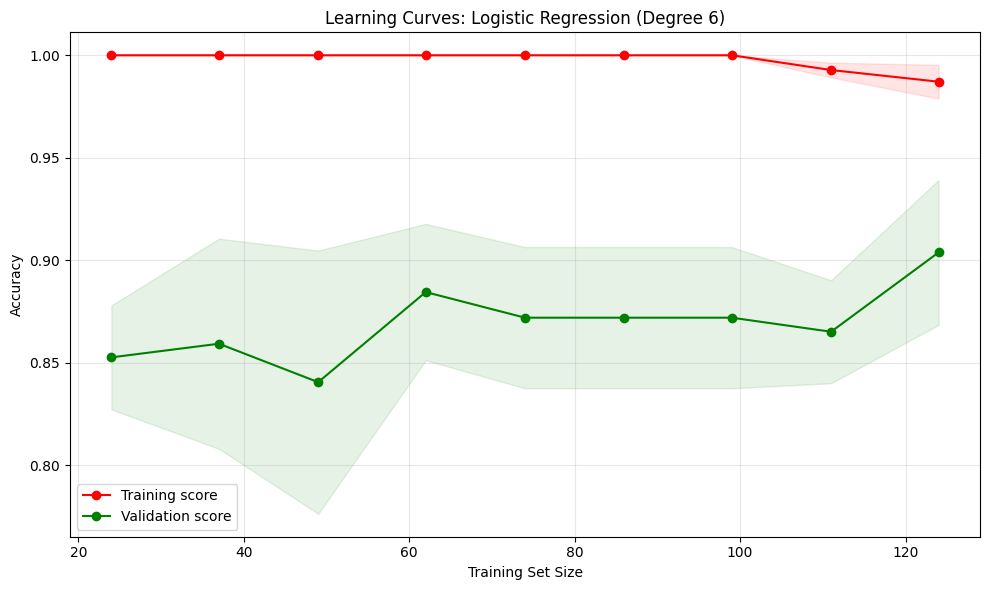

All results saved to ../../Results/logreg_Ch1_deg_6.csv


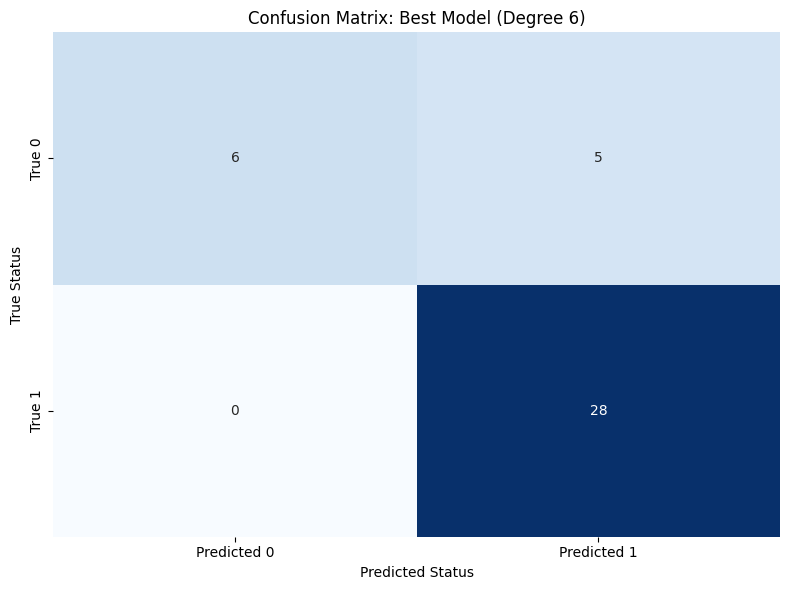

In [16]:
print("Best params (CV on train):", grid.best_params_)
print("Best mean CV accuracy (train):", grid.best_score_)

# Refit on full TRAIN and evaluate once on TEST
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)


y_pred = best_model.predict(X_test)
print("\n=== FINAL TEST EVALUATION ===")
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Added: Learning curves for degree 6
print("\n=== Generating Learning Curves (Deg 6) ===")
train_sizes, train_scores, val_scores = learning_curve(
    grid.best_estimator_, X_train, y_train, 
    cv=GroupKFold(n_splits=5), groups=groups_train,
    train_sizes=np.linspace(0.1, 1.0, 10), 
    scoring='accuracy', n_jobs=n_job)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves: Logistic Regression (Degree 6)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../../Figures/logreg_learning_curve_deg6.png", dpi=300, bbox_inches='tight')
plt.show()

# === After grid search ===
# Save all CV results
results_df = pd.DataFrame(grid.cv_results_)


#Do not save, dataset i did as big as it realistically gets



# Extract relevant info
records = []
for i, row in results_df.iterrows():
    params = row["params"]
    solver = params["logreg__solver"]
    degree = params["poly__degree"]
    penalty = params["logreg__penalty"]
    C = params["logreg__C"]
    l1_ratio = params.get("logreg__l1_ratio", None)
    
    record = {
        "method": "LogisticRegression",
        "solver": solver,
        "degree": degree,
        "alpha": 1.0 / C,   # inverse of C
        "generalization": penalty if penalty != "elasticnet" else f"elasticnet(l1_ratio={l1_ratio})",
        "score": row["mean_test_score"]
    }
    records.append(record)

summary_df = pd.DataFrame(records)

# Save to CSV
summary_df.to_csv("../../Results/logreg_Ch1_deg_6.csv", index=False)
print("All results saved to ../../Results/logreg_Ch1_deg_6.csv")

#Confusion
y_pred = grid.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
# Use seaborn for a nice heatmap visualization
sns.heatmap(
    cm,
    annot=True,
    fmt='d', # 'd' formats the numbers as integers
    cmap='Blues',
    cbar=False,
    xticklabels=['Predicted 0', 'Predicted 1'],
    yticklabels=['True 0', 'True 1']
)
plt.xlabel('Predicted Status')
plt.ylabel('True Status')
plt.title('Confusion Matrix: Best Model (Degree 6)')
plt.tight_layout()
plt.savefig("../../Figures/logreg_confusion_deg6.png", dpi=300, bbox_inches='tight')
plt.show()


MODEL EVALUATION


Best CV Score (Train): 0.9103
Test Accuracy          : 0.8718
Test ROC-AUC           : 0.9838

Train-Test Gap       : 0.0385
Good generalization

Best Parameters:
Polynomial Degree: 6
Regularization C : 0.0825
Penalty          : l2


Best CV Score (Train): 0.9103
Test Accuracy          : 0.8718
Test ROC-AUC           : 0.9838

Train-Test Gap       : 0.0385
Good generalization

Best Parameters:
Polynomial Degree: 6
Regularization C : 0.0825
Penalty          : l2


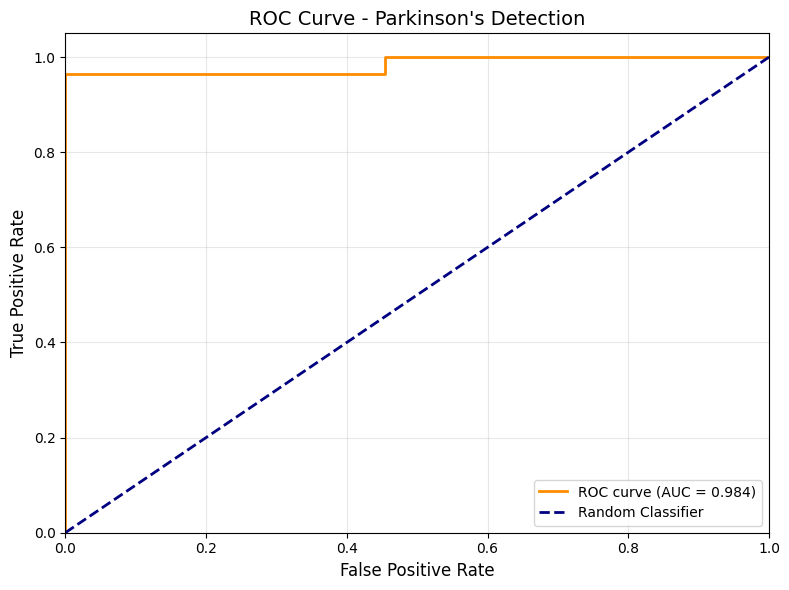

MODEL COEFFICIENTS

Intercept: 7.0066
Total features after polynomial expansion: 27131

Top 15 Most Important Features:
                         Feature  Coefficient  Abs_Coefficient
          MDVP:Flo(Hz) NHR HNR^4     0.051964         0.051964
           MDVP:Fo(Hz)^4 NHR HNR    -0.050157         0.050157
MDVP:Flo(Hz) MDVP:APQ HNR^3 RPDE    -0.048029         0.048029
         MDVP:Fo(Hz)^3 NHR HNR^2    -0.047214         0.047214
                    RPDE^2 DFA^4     0.046945         0.046945
                       NHR HNR^5     0.044289         0.044289
        MDVP:Flo(Hz)^2 NHR HNR^3     0.042878         0.042878
                      HNR^3 D2^3     0.042801         0.042801
             HNR^2 DFA^3 spread2    -0.042388         0.042388
                    RPDE^3 DFA^3     0.041942         0.041942
                HNR RPDE^2 DFA^3     0.041023         0.041023
        MDVP:Fo(Hz) RPDE^2 DFA^3     0.040336         0.040336
               HNR DFA^3 spread2    -0.039931         0.03993

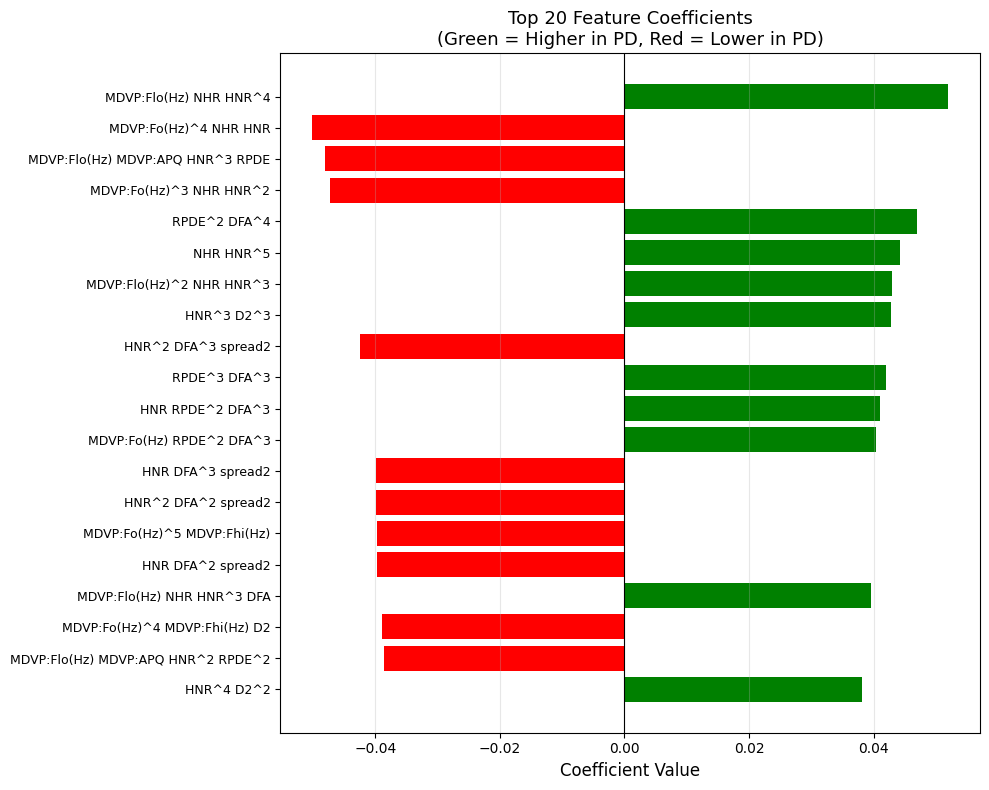

In [17]:
#testing for overfitting usin g simple train-test gap as metric
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("MODEL EVALUATION\n")
print("=" * 60)
print(f"\nBest CV Score (Train): {grid.best_score_:.4f}")
print(f"Test Accuracy          : {accuracy_score(y_test, y_pred):.4f}")
print(f"Test ROC-AUC           : {roc_auc_score(y_test, y_pred_proba):.4f}")

# Overfitting check
gap = grid.best_score_ - accuracy_score(y_test, y_pred)
print(f"\nTrain-Test Gap       : {gap:.4f}")
if abs(gap) < 0.05:
    print("Good generalization")
elif abs(gap) < 0.10:
    print("Slight overfitting detected")
else:
    print("Significant overfitting")

print(f"\nBest Parameters:")
print(f"Polynomial Degree: {grid.best_params_['poly__degree']}")
print(f"Regularization C : {grid.best_params_['logreg__C']:.4f}")
print(f"Penalty          : {grid.best_params_['logreg__penalty']}")

#Roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Parkinson\'s Detection', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#Model coefficients

print("MODEL COEFFICIENTS")
print("=" * 60)
logreg = best_model.named_steps['logreg']
poly = best_model.named_steps['poly']

# Get feature names
if hasattr(poly, 'get_feature_names_out'):
    feature_names = poly.get_feature_names_out()
else:
    feature_names = [f"feature_{i}" for i in range(len(logreg.coef_[0]))]

coefficients = logreg.coef_[0]
intercept = logreg.intercept_[0]

print(f"\nIntercept: {intercept:.4f}")
print(f"Total features after polynomial expansion: {len(coefficients)}")

# Top coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 15 Most Important Features:")
print(coef_df.head(15).to_string(index=False))

# Plot top coefficients
plt.figure(figsize=(10, 8))
top_n = 20
top_coefs = coef_df.head(top_n)
colors = ['red' if x < 0 else 'green' for x in top_coefs['Coefficient']]
plt.barh(range(len(top_coefs)), top_coefs['Coefficient'].values, color=colors)
plt.yticks(range(len(top_coefs)), top_coefs['Feature'].values, fontsize=9)
plt.xlabel('Coefficient Value', fontsize=12)
plt.title(f'Top {top_n} Feature Coefficients\n(Green = Higher in PD, Red = Lower in PD)', fontsize=13)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)

### Analysis:

------------------------------------------------------------------------------------------------------------------------------------------------------

It seems that best degree is between degree 3 and 5, getting us highest accuracy and results for minimal complexity, with l2 being the best generalization method overall using lbfgs solver.

Our relation with the output is clearly non-linear, as multi-degree models far outdo simple degree 1 models.

We are always capturing all true positives, but struggle with tru negatives. We care most about classifying all true positives correctly, with secondary focus on true negatives, due to caring more about classifying PD patients, than falsely classifying healthy, as one is more of an issue. So we don't mind the results, but we would like to improve our accuracy overall.

We will try to see how we can check why misclassification is happening in the first place.



### Checking why misclassification happens:

We will start more general, see how far from the decision threshold the misclassified points are

In [18]:
y_proba = best_model.predict_proba(X_test)[:,1]
# Make a DataFrame to inspect
results_df = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': y_pred,
    'Probability Class 1': y_proba
})

# Add a column to identify misclassifications
results_df['Correct?'] = results_df['True Label'] == results_df['Predicted Label']
results_df['Distance from 0.5'] = np.abs(results_df['Probability Class 1'] - 0.5)

# Sort misclassifications by how close the model was to flipping the decision
close_calls = results_df[results_df['Correct?'] == False].sort_values(by='Distance from 0.5')

print(close_calls.head(10))  # Look at the 10 closest incorrect predictions

     True Label  Predicted Label  Probability Class 1  Correct?  \
171           0                1             0.601444     False   
185           0                1             0.627283     False   
176           0                1             0.680812     False   
190           0                1             0.773467     False   
35            0                1             0.820117     False   

     Distance from 0.5  
171           0.101444  
185           0.127283  
176           0.180812  
190           0.273467  
35            0.320117  


It seems that, for some examples, we are quite away from the correct threshold (atleast for degree 6 model, could be more/less elsewhere) which is bad. The way we can solve our issue is a better model or even giving higher balance/weight towards 1, defining the true label to be from below 0.5 and up (shifting the decision boundary downwards), or perhaps a better dataset that is more balanced between 0 and 1s.

In any case, we will look at the most extreme result of the misclassified to see what happened:

In [19]:
extreme_case_index = 35  #replace with index of interest

X_test.loc[extreme_case_index]

MDVP:Fo(Hz)       201.464000
MDVP:Fhi(Hz)      210.565000
MDVP:Flo(Hz)      195.708000
MDVP:Jitter(%)      0.001980
Shimmer:APQ3        0.005860
MDVP:APQ            0.009570
NHR                 0.001350
HNR                31.732000
RPDE                0.344252
DFA                 0.742737
spread2             0.170183
D2                  2.447064
PPE                 0.057610
Name: 35, dtype: float64

See the means for clsas = 0 and class = 1, and see contribution of each feature to the decision:

In [20]:
#Comapre the misclassifeid example features to each class's mean 
row_raw = X_test.loc[extreme_case_index]

class0_mean = X_train[y_train==0].mean()
class1_mean = X_train[y_train==1].mean()

comparison_df = pd.DataFrame({
    'row_raw': row_raw,
    'class0_mean': class0_mean,
    'class1_mean': class1_mean
})
print(comparison_df)

logreg = best_model.named_steps['logreg']
preprocessor = best_model[:-1]

# Transform the row to match model input space
row_transformed = preprocessor.transform(row_raw.to_frame().T)  # shape (1, n_features)

#Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

#Create a Series for transformed row
row_transformed_series = pd.Series(row_transformed.flatten(), index=feature_names)

#Coefficients in transformed space
coefs = pd.Series(logreg.coef_[0], index=feature_names)

contrib = row_transformed_series * coefs
#top features pushing towards class 1 (largest positive contributions)
top_class1 = contrib.sort_values(ascending=False).head(10)

#top features pushing towards class 0 (largest negative contributions)
top_class0 = contrib.sort_values().head(10)

print("\nTop features pushing towards class 1:")
print(top_class1)

print("\nTop features pushing towards class 0:")
print(top_class0)

                   row_raw  class0_mean  class1_mean
MDVP:Fo(Hz)     201.464000   182.585865   145.349782
MDVP:Fhi(Hz)    210.565000   230.544459   189.734261
MDVP:Flo(Hz)    195.708000   148.980135   107.335958
MDVP:Jitter(%)    0.001980     0.004096     0.006982
Shimmer:APQ3      0.005860     0.009295     0.017765
MDVP:APQ          0.009570     0.013057     0.027912
NHR               0.001350     0.012971     0.028280
HNR              31.732000    24.467324    20.963017
RPDE              0.344252     0.447031     0.516379
DFA               0.742737     0.693963     0.726888
spread2           0.170183     0.166888     0.248621
D2                2.447064     2.143160     2.454355
PPE               0.057610     0.122910     0.233914

Top features pushing towards class 1:
HNR^4 D2^2                 0.207600
HNR^3 D2^3                 0.182214
HNR^3 D2^2                 0.170026
MDVP:Flo(Hz) HNR^2 D2^3    0.159284
HNR^3 DFA D2^2             0.149946
MDVP:Fo(Hz) HNR^3 D2^2     0.145000
MDV

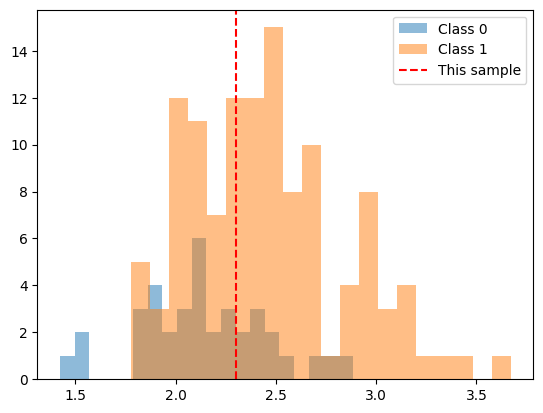

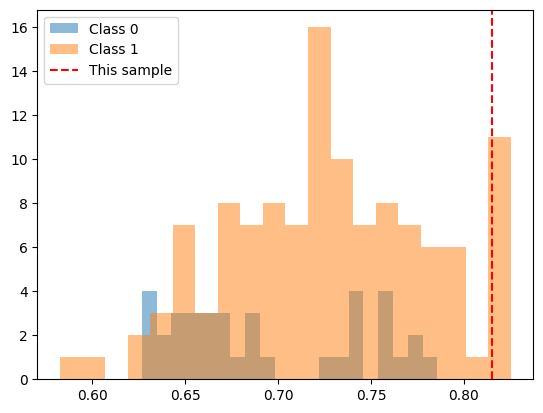

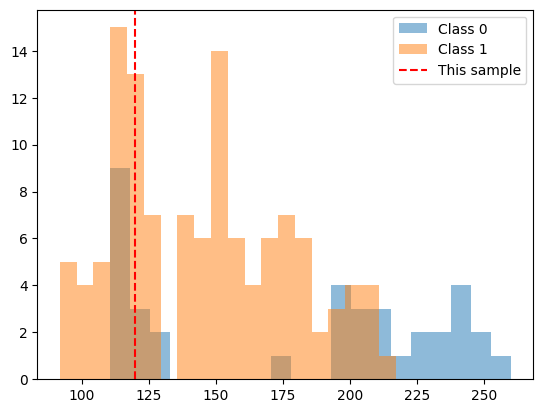

In [21]:
row = X_test.iloc[0]  

#To see effect of particular feature on prediction:
feature = 'D2'
plt.hist(X_train.loc[y_train==0, feature], bins=20, alpha=0.5, label='Class 0')
plt.hist(X_train.loc[y_train==1, feature], bins=20, alpha=0.5, label='Class 1')
plt.axvline(row[feature], color='red', linestyle='--', label='This sample')
plt.legend()
plt.show()

feature = 'DFA'
plt.hist(X_train.loc[y_train==0, feature], bins=20, alpha=0.5, label='Class 0')
plt.hist(X_train.loc[y_train==1, feature], bins=20, alpha=0.5, label='Class 1')
plt.axvline(row[feature], color='red', linestyle='--', label='This sample')
plt.legend()
plt.show()

feature = 'MDVP:Fo(Hz)'
plt.hist(X_train.loc[y_train==0, feature], bins=20, alpha=0.5, label='Class 0')
plt.hist(X_train.loc[y_train==1, feature], bins=20, alpha=0.5, label='Class 1')
plt.axvline(row[feature], color='red', linestyle='--', label='This sample')
plt.legend()
plt.show()

So we see our misclassifcation occurs due to key features being in the region where most examples were classified as class 1 rather than class 0, hence the misclassification.

This tells us that logistic regression is not doing good enough of a job seperating the two classes, perhaps due to limitations on degrees or just not finding the optimal alpha for regualrization.

To finally show that our dataset is indeed not linearly seperable, we will use PCA. If it clusters successfully and cleanly, then we have a linearly seperable class, and is solvable using linear methods (achieving near 100% accuracy). If not, we need non-linearity to do any good (NNs and such).

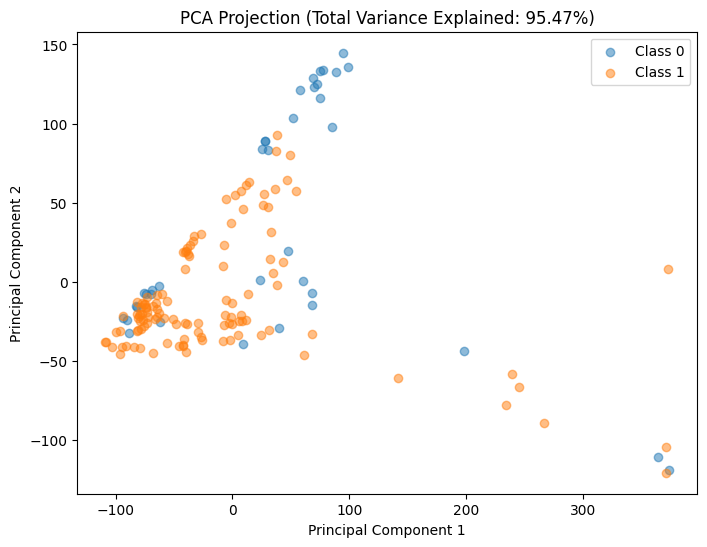

In [22]:
from sklearn.decomposition import PCA
# Fit PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Compute total variance explained
total_var = pca.explained_variance_ratio_.sum() * 100

# Plot PCA projection
plt.figure(figsize=(8,6))
plt.scatter(X_pca[y_train == 0, 0], X_pca[y_train == 0, 1], label='Class 0', alpha=0.5)
plt.scatter(X_pca[y_train == 1, 0], X_pca[y_train == 1, 1], label='Class 1', alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'PCA Projection (Total Variance Explained: {total_var:.2f}%)')
plt.legend()
plt.show()

Clearly not a clean split of 2 classes, we will need non-linearity, so need to use degrees for other linear models (SVMs) to make it be able to capture non-linearity. Or we switch to another dataset, and see the type of distribution we get there (could be more linear).

### Analysis

------------------------------------------------------------------------------------------------------------------------------------------------------

It seems the reason we are misclassifying it here is due to the main features all falling within class 1 classification territory, thus making the model mistake it for a class 1, we need better seperation of the 2 classes to do better.

Our inputs and output are most definitely not linear.

## Chapter 1 Conclusion:

Degree 3 and 4 seem to be the best, giving the highest, most consistent test resutls

Our relationship between inputs and outputs is not linear, and needs degrees in logistic to do any good.

Our dataset is small, and we'll need a bigger dataset to be able to generalize better.

We need to do groupstratifiedkfold to avoid having multiple voices from same patient be in different sets (test, train, val).

------------------------------------------------------------------------------------------------------------------------------------------------------

## Summary: Model Variant Comparison

Comparison of all tested polynomial degrees with different regularization strategies to identify optimal configuration.

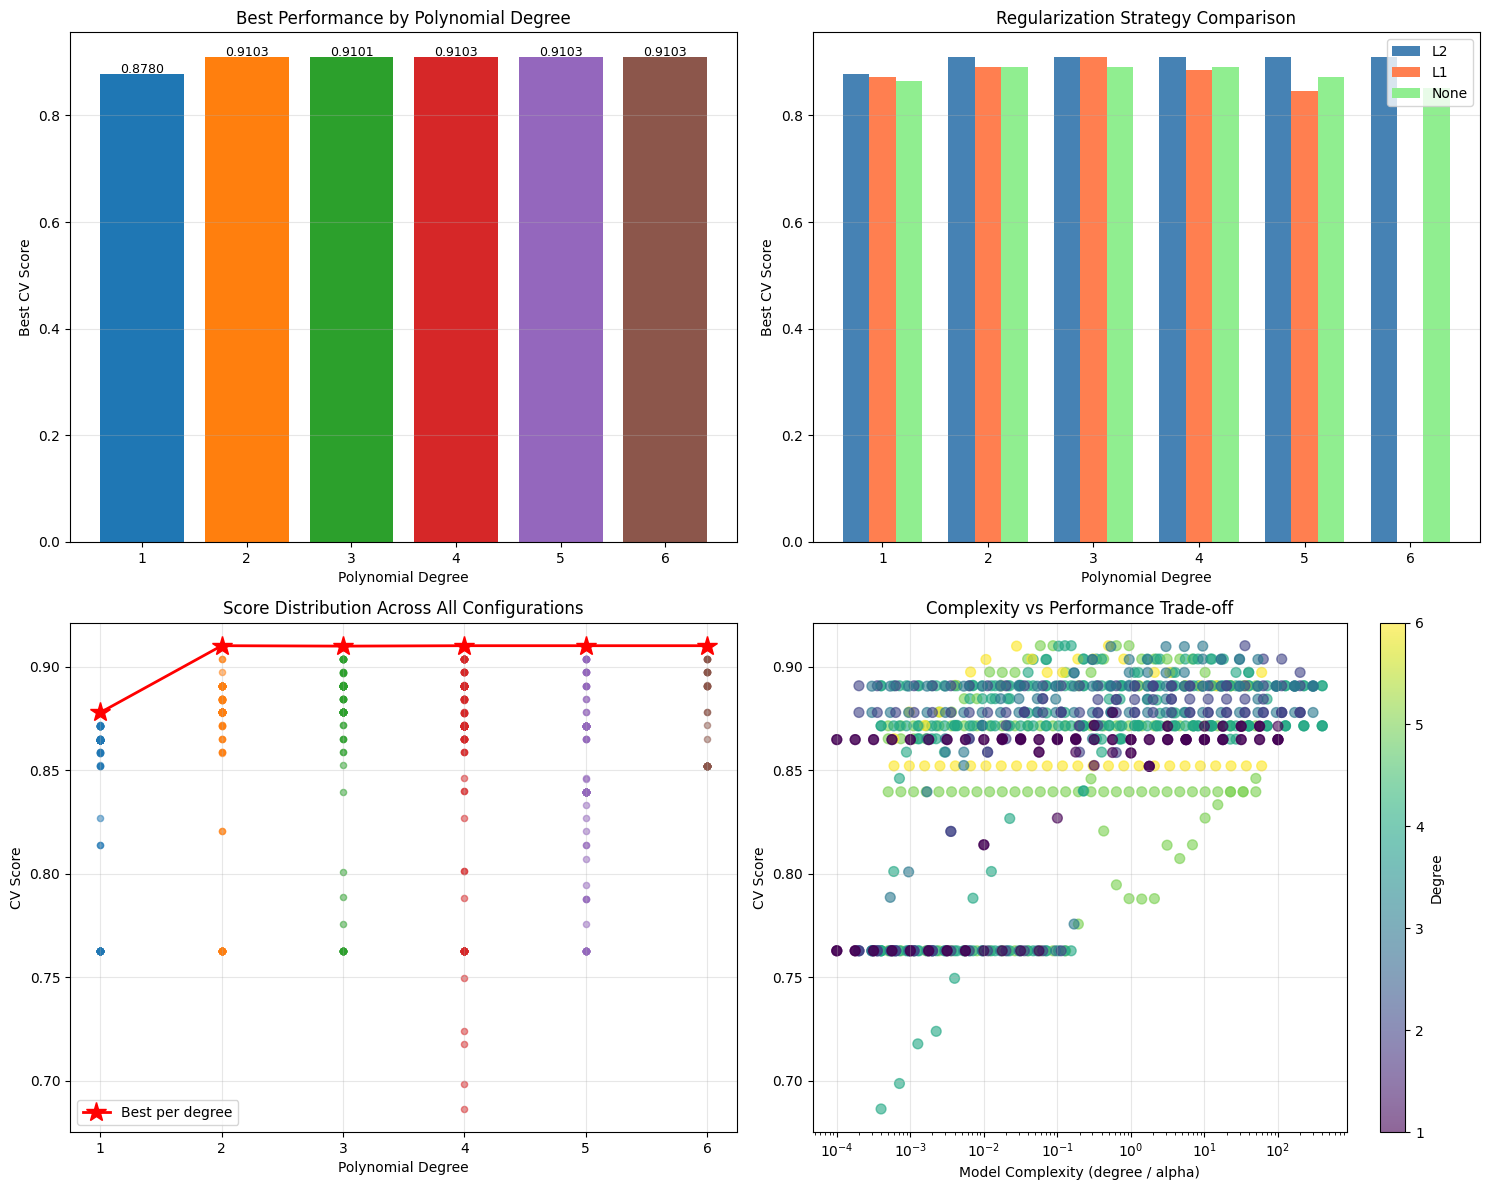

LOGISTIC REGRESSION: COMPREHENSIVE SUMMARY

Total configurations tested: 790
Polynomial degrees tested: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

Best overall score: 0.9103
Best configuration:
  - Degree: 5
  - Regularization: l2
  - Alpha: 85.3168
  - C: 0.0117


Best score per degree:
  Degree 1: 0.8780 (l2, C=0.56)
  Degree 2: 0.9103 (l2, C=17.78)
  Degree 3: 0.9101 (l1, C=3.16)
  Degree 4: 0.9103 (l2, C=0.04)
  Degree 5: 0.9103 (l2, C=0.01)
  Degree 6: 0.9103 (l2, C=0.08)


Summary saved to ../../Results/logreg_summary_best_per_degree.csv


In [24]:
# Added: Comprehensive comparison of all model variants tested
# Load all result files and create comparison visualizations

import pandas as pd
import glob

# Load all logistic regression results
result_files = glob.glob("../../Results/logreg_*.csv")
all_results = []
for file in result_files:
    df_temp = pd.read_csv(file)
    all_results.append(df_temp)

if all_results:
    df_all = pd.concat(all_results, ignore_index=True)
    
    # Get best model per degree
    best_per_degree = df_all.groupby('degree').apply(lambda x: x.loc[x['score'].idxmax()])
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Best score per degree
    axes[0, 0].bar(best_per_degree['degree'], best_per_degree['score'], 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'][:len(best_per_degree)])
    axes[0, 0].set_xlabel('Polynomial Degree')
    axes[0, 0].set_ylabel('Best CV Score')
    axes[0, 0].set_title('Best Performance by Polynomial Degree')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    for i, (deg, score) in enumerate(zip(best_per_degree['degree'], best_per_degree['score'])):
        axes[0, 0].text(deg, score + 0.002, f'{score:.4f}', ha='center', fontsize=9)
    
    # 2. Regularization impact - Fixed to handle different degree coverage
    all_degrees = sorted(df_all['degree'].unique())
    l2_scores = []
    l1_scores = []
    none_scores = []
    
    for deg in all_degrees:
        l2_data = df_all[(df_all['generalization'] == 'l2') & (df_all['degree'] == deg)]
        l1_data = df_all[(df_all['generalization'] == 'l1') & (df_all['degree'] == deg)]
        none_data = df_all[(df_all['generalization'].isna() | (df_all['generalization'] == 'None')) & (df_all['degree'] == deg)]
        
        l2_scores.append(l2_data['score'].max() if len(l2_data) > 0 else 0)
        l1_scores.append(l1_data['score'].max() if len(l1_data) > 0 else 0)
        none_scores.append(none_data['score'].max() if len(none_data) > 0 else 0)
    
    x = np.arange(len(all_degrees))
    width = 0.25
    axes[0, 1].bar(x - width, l2_scores, width, label='L2', color='steelblue')
    axes[0, 1].bar(x, l1_scores, width, label='L1', color='coral')
    axes[0, 1].bar(x + width, none_scores, width, label='None', color='lightgreen')
    axes[0, 1].set_xlabel('Polynomial Degree')
    axes[0, 1].set_ylabel('Best CV Score')
    axes[0, 1].set_title('Regularization Strategy Comparison')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(all_degrees)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. Score distribution by degree
    for degree in sorted(df_all['degree'].unique()):
        degree_scores = df_all[df_all['degree'] == degree]['score']
        axes[1, 0].scatter([degree]*len(degree_scores), degree_scores, alpha=0.5, s=20)
    axes[1, 0].plot(best_per_degree['degree'], best_per_degree['score'], 'r*-', 
                    markersize=15, linewidth=2, label='Best per degree')
    axes[1, 0].set_xlabel('Polynomial Degree')
    axes[1, 0].set_ylabel('CV Score')
    axes[1, 0].set_title('Score Distribution Across All Configurations')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Complexity vs Performance
    df_all['complexity'] = df_all['degree'] / df_all['alpha']  # Degree normalized by regularization strength
    axes[1, 1].scatter(df_all['complexity'], df_all['score'], alpha=0.6, c=df_all['degree'], cmap='viridis', s=50)
    axes[1, 1].set_xlabel('Model Complexity (degree / alpha)')
    axes[1, 1].set_ylabel('CV Score')
    axes[1, 1].set_title('Complexity vs Performance Trade-off')
    axes[1, 1].set_xscale('log')
    cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1], label='Degree')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("../../Figures/logreg_comprehensive_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("=" * 70)
    print("LOGISTIC REGRESSION: COMPREHENSIVE SUMMARY")
    print("=" * 70)
    print(f"\nTotal configurations tested: {len(df_all)}")
    print(f"Polynomial degrees tested: {sorted(df_all['degree'].unique())}")
    print(f"\nBest overall score: {df_all['score'].max():.4f}")
    best_config = df_all.loc[df_all['score'].idxmax()]
    print(f"Best configuration:")
    print(f"  - Degree: {best_config['degree']}")
    print(f"  - Regularization: {best_config['generalization']}")
    print(f"  - Alpha: {best_config['alpha']:.4f}")
    print(f"  - C: {1/best_config['alpha']:.4f}")
    
    print(f"\n\nBest score per degree:")
    for _, row in best_per_degree.iterrows():
        print(f"  Degree {int(row['degree'])}: {row['score']:.4f} ({row['generalization']}, C={1/row['alpha']:.2f})")
    
    # Save summary
    best_per_degree.to_csv("../../Results/logreg_summary_best_per_degree.csv", index=False)
    print("\n\nSummary saved to ../../Results/logreg_summary_best_per_degree.csv")
else:
    print("No result files found. Please run the hyperparameter search cells first.")